# Codigo - Proyecto : Modelo de Ramsey - FCFM U.Chile

MA4703 – Control Óptimo: Teoría y Laboratorio

Profesor: Héctor Ramírez C.
Auxiliar: Diego Olguín Wende 
Ayudantes: Carlos Antil y Luis Fuentes Cruz

Noviembre 2024. 

**Integrantes Grupo 1:**
1. Allen Arroyo
2. Isidora Miranda 


Referencias del codigo : 

1. https://discourse.julialang.org/t/solving-boundary-value-differential-equation-problems-for-economics/72871
2. https://www.mathworks.com/company/technical-articles/simulating-the-ramsey-cass-koopmans-model-using-matlab-and-simulink.html
3. https://discourse.julialang.org/t/solving-the-4-quadrants-of-dynamic-optimization-problems-in-julia-help-wanted/73285/5

In [1]:
import Pkg
#Pkg.add("JuMP")
#Pkg.add("DifferentialEquations")
#Pkg.add("Ipopt")
#Pkg.add("LinearAlgebra")
#Pkg.add("OptimalControl")
#Pkg.add("NLPModelsIpopt")
#Pkg.add("Plots")
#Pkg.add("BenchmarkTools")
#Pkg.add("Interpolations")
#Pkg.add("QuadGK")
#Pkg.add("CairoMakie")
#Pkg.add("PlotUtils")

In [2]:
import Pkg

using JuMP
using DifferentialEquations
using Ipopt, LinearAlgebra
using OptimalControl
using NLPModelsIpopt
using Plots
#using BenchmarkTools

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


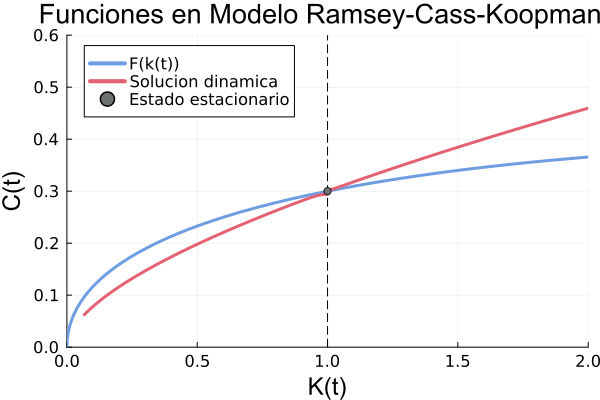

In [3]:
n=0
# Parámetros como vector
p = [0.4, 0.5, 0.1, 0.1, 0.5]  # A, α, δ, ρ, σ

"Función Neoclasica de producción standar" 
function F(x, p::Vector)
    A, α, δ, _, _ = p
    return (A * x^α - (n+δ) * x)
end

"Dinamica de Ramsey-Cass-Koompans acoplada"
function ramsey!(du, u, p::Vector, t)
    # Parámetros del vector
    A, α, δ, ρ, σ = p

    # Variables
    K, C = u
    
    # Sistema ODE, donde K'=F(k)- (δ+n)K - C y C' = (α * A * K^(α - 1) - δ - ρ) * (σ) * C
    
    du[1] = -(A * K^α - (δ+n) * K - C)
    du[2] = -(α * A * K^(α - 1) -δ - ρ) * (σ) * C
    nothing
end

"Estado estacionario C_ss y K_ss"
function ss(p::Vector)
    # Parámetros del vector
    A, α, δ, ρ, _ = p

    # Estado estacionario
    Kss = (α * A / (δ + ρ))^(1 / (1 - α))
    Css = A * Kss^α - (δ+n) * Kss

    return Kss, Css
end

# Estado estacionario
Kss, Css = ss(p)

# Ejecutar el sistem inverso | iniciar por debajo del estado estacionario
tspan = (0.0, 50)
tweak = 0.98
u0 = [0.999999 * Kss; 0.999999 * tweak * Css]
ode = ODEProblem(ramsey!, u0, tspan, p)
sol1 = DifferentialEquations.solve(ode, abstol=1e-8, reltol=1e-8)

# Función de política C = ϕ(K)
plt = plot(
    title="Funciones en Modelo Ramsey-Cass-Koopmans",
    xlims=(0, 2 * Kss),
    ylims=(0, 2 * Css),
    xlabel="K(t)",
    ylabel="C(t)",
)

# Dibujar nullclines
plot!(plt, x -> F(x, p), 0, 2, color=:"#6E9DE2" , linewidth=3, label="F(k(t))",titlefont = ("Arial", 18, :bold),legendfontsize = 11, guidefont = ("Arial", 16),tickfontsize = 11)
vline!(plt, [Kss], color=:black, linewidth=1,label=nothing,linestyle=:dash)

plot!(plt, sol1, xflip=false, vars=(1, 2), xlims=(0, 2 * Kss), ylims=(0, 2 * Css), color=:"#E36173", linewidth=3,label="Solucion dinamica",legendfontsize = 11)

# Ejecutar el sistem inverso | iniciar por arriba del estado estacionario
tspan = (0, 100.0)
tweak = 1.01
u0 = [1.00001 * Kss; 1.00001 * tweak * Css]
ode = ODEProblem(ramsey!, u0, tspan, p)
sol2 = DifferentialEquations.solve(ode, abstol=1e-8, reltol=1e-8)
plot!(plt, sol2, xflip=false, vars=(1, 2), xlims=(0, 2 * Kss), ylims=(0, 2 * Css), color=:"#E36173", linewidth=3, label=nothing)

# Estetica grafico :  
scatter!((1.0, 0.3), label=["Estado estacionario" "."], color=:"#6D7273")

#savefig(plt, "ramsey-stable-arm.png")


In [8]:
K1_nuevo(t) = sol1(50-t)[1]
C1_nuevo(t) = sol1(50-t)[2]

C1_nuevo (generic function with 1 method)

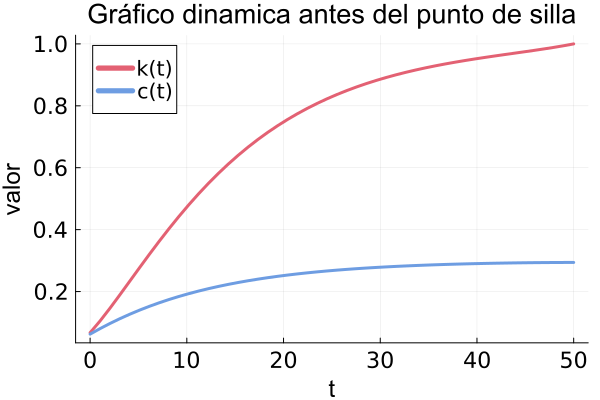

In [9]:
t1_values = range(0, stop=50, length=50)

K1_values = [K1_nuevo(t) for t in t1_values]
C1_values = [C1_nuevo(t) for t in t1_values]

plot(t1_values, K1_values, label="k(t)", xlabel="t", ylabel="valor", title="Gráfico dinamica antes del punto de silla", color = "#E36173", linewidth=3,titlefont = ("Arial", 18, :bold),legendfontsize = 14, guidefont = ("Arial", 16),tickfontsize = 15)
plot!(t1_values, C1_values, label="c(t)",color = "#6E9DE2", linewidth=3,legendfontsize = 14)


In [10]:
K2_nuevo(t) = sol2(100-t)[1]
C2_nuevo(t) = sol2(100-t)[2]

C2_nuevo (generic function with 1 method)

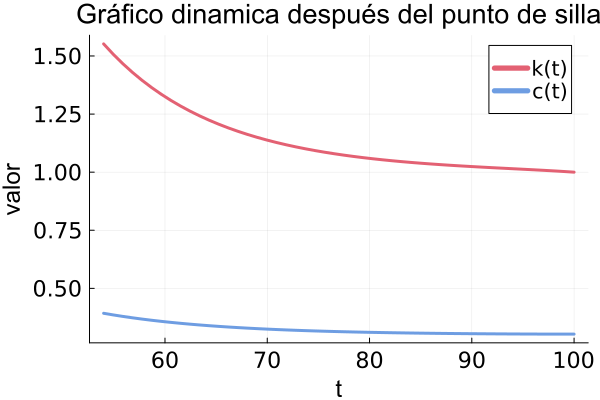

In [11]:
t2_values = range(54, stop=100, length=50)
K2_values = [K2_nuevo(t) for t in t2_values]
C2_values = [C2_nuevo(t) for t in t2_values]

plot(t2_values, K2_values, label="k(t)", xlabel="t", ylabel="valor", title="Gráfico dinamica después del punto de silla", color = "#E36173", linewidth=3,titlefont = ("Arial", 18, :bold),legendfontsize = 14, guidefont = ("Arial", 16),tickfontsize = 15)
plot!(t2_values, C2_values, label="c(t)",color = "#6E9DE2", linewidth=3,legendfontsize = 14)


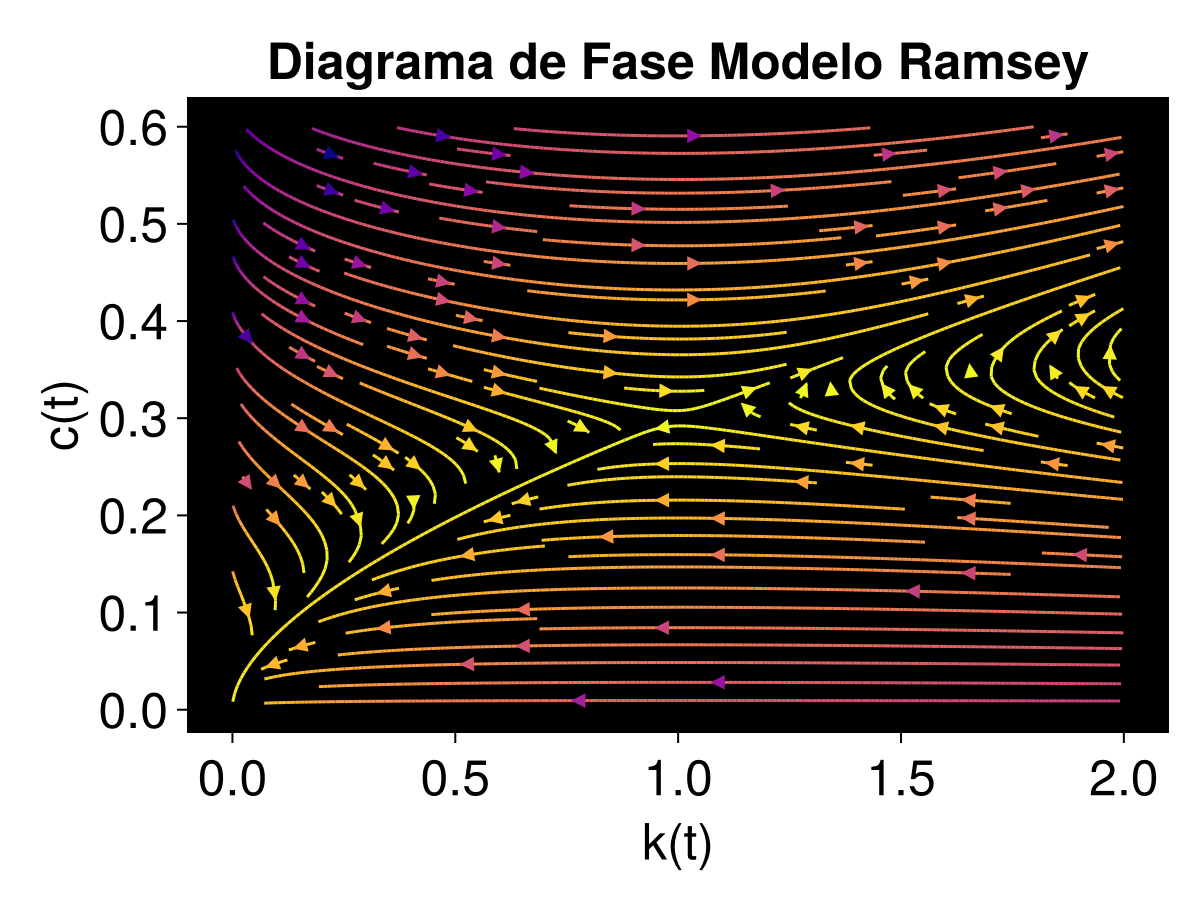

CairoMakie.Screen{IMAGE}


In [12]:
using CairoMakie
p = [0.4, 0.5, 0.1, 0.1, 0.5]  # A, α, δ, ρ, σ

"Diagrama de fase de modelo Ramsey-Cass-Koompans acoplada para (K,C)"

function ramseyEq(K, C, p)
    A, α, δ, ρ, σ = p[1], p[2], p[3], p[4], p[5]

    dK = -(A * K^α - (δ+n) * K - C)
    dC = -(α * A * K^(α - 1) -(δ) - ρ) * σ * C
    return Point(dK, dC)
end

let
    fig = Figure(fontsize = 25)
    ax = Axis(fig, xlabel="k(t)", ylabel="c(t)", title="Diagrama de Fase Modelo Ramsey", backgroundcolor = :black)
    streamplot!(ax, (x,y)->ramseyEq(x,y,p), 0..2*Kss, 0..2*Css, colormap = Reverse(:plasma),
        gridsize= (32,32), arrow_size = 10)
    fig[1, 1] = ax
    display(fig)
    save("ramsey-streamplot.png", fig)
end